In [512]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import os
import ast
import sklearn
import gensim
import en_core_web_lg
import ast

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from nltk.corpus import words

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [542]:
df_big_easy_clean = pd.read_csv('../data/processed_data/df_big_easy_clean.csv')
df_big_easy_clean['review_parts_clean'] = df_big_easy_clean['review_parts_clean'].apply(ast.literal_eval)
df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_clean,review_parts_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-08,staff marco point covid guide line service gen...,[staff marco point covid guide line service ge...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-07,counter reservations apparently dont give tabl...,[counter reservations apparently dont give tab...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-07,good food foul smell find every time time ever...,"[good food, foul smell find every time, time ..."
3,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-07,british pub amazing line draft beers truffel c...,[british pub amazing line draft beers truffel ...
4,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-07,wait m get serve bar waste sizeable chunk lunc...,[wait m get serve bar waste sizeable chunk lun...


In [466]:
idx = 8
print(df_big_easy_clean['reviewBody'][idx], '\n\n',
      df_big_easy_clean['review_clean'][idx], '\n\n',
      df_big_easy_clean['review_parts_clean'][idx])

Very poor service made worst by inedible food. We waited 30mins for a table, but when we sat down found that a third of the place was empty...? Unless that many people left all at once? We sat at the front all that time and didn't see that many people leave. Why this was, was made clear later. Very friendly waiter took our very simple order, 3 meat platters 3 cokes. Unfortunately it took 3 reminders over the period of an hour to even get our drinks! I don't think I've ever waited that long for a soft drink. No apology made. Took a further 50mins to get our food. All the while the place was still only a third full. Each of us had ribs, half chicken, some pull pork, chili beans, chips and corn bread muffin. The chicken was well cooked, moist but very bland, there wasn't much in the way of any discernable seasoning. Pulled pork was dry and cold. Ribs are the worst ribs I've ever had, tough as old boots. I've got a decent set of canines but couldn't get through one, they were that tough. T

In [150]:
df_big_easy_clean.shape

(614, 5)

# NLP stuff

### Basic analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

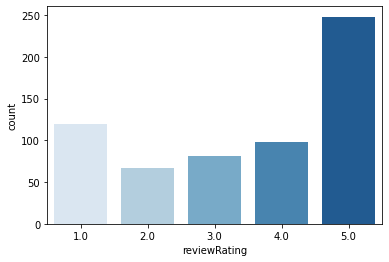

In [152]:
sns.countplot(data=df_big_easy_clean,
              x='reviewRating',
              palette='Blues')

Look over time

In [160]:
df_big_easy_clean['date_clean'] = df_big_easy_clean['date_clean'].astype('datetime64[D]')
df_monthly = df_big_easy_clean.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count'))
df_monthly #= df_monthly.query('')

,mean,count
date_clean,,
2020-08-31,3.581395,301
2020-09-30,4.000000,2
2020-10-31,4.222222,9
2020-11-30,3.755102,49
2020-12-31,3.304348,23
2021-01-31,3.400000,20
2021-02-28,5.000000,2
2021-03-31,2.333333,3
2021-04-30,5.000000,1


(-0.5, 399.5, 199.5, -0.5)

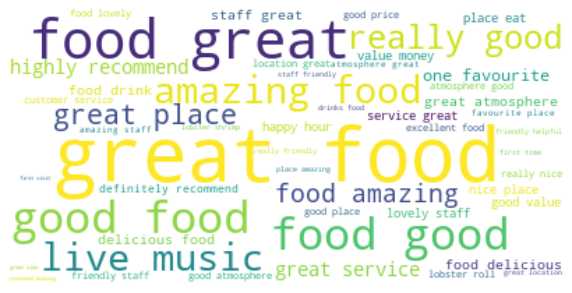

In [454]:
from wordcloud import WordCloud

wc = WordCloud(prefer_horizontal=1,
               max_words=50,
               background_color='white',
               collocations=True,
               collocation_threshold=3,
               normalize_plurals=True,
               min_word_length=2,
               relative_scaling=1)

df_filt = df_big_easy_clean.query(f'reviewRating>=5 and reviewRating<=5')
reviews = [re.sub(r'(big easy|canary wharf)', '', s) for s in df_filt['review_clean']]
wc.generate(' '.join(reviews))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

#### TF-IDF, but making sure we don't double count reversed n grams (e.g. treat 'great food' and 'food great' as one single n gram)

(187, 110)
(179, 110)
(248, 110)


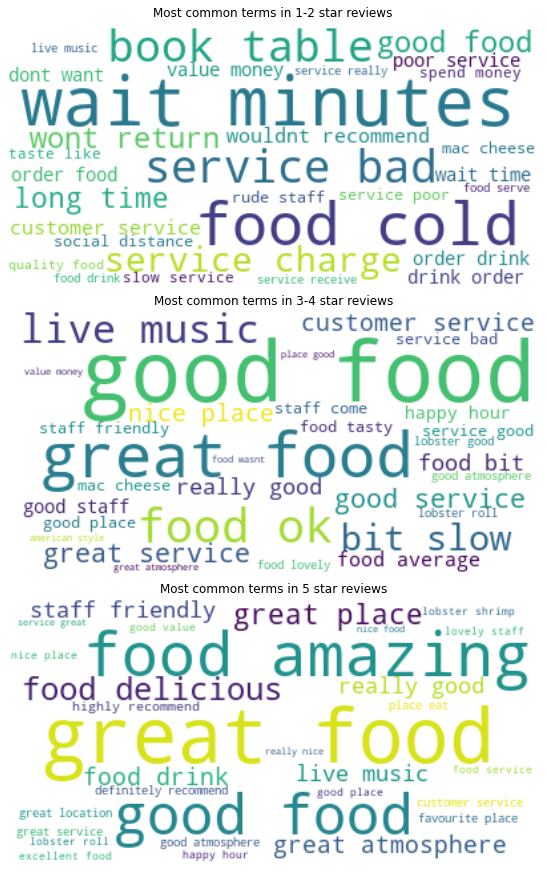

In [550]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,12),
                        constrained_layout=True)

    
# Set up word cloud
wc = WordCloud(prefer_horizontal=1,
           max_words=100,
           background_color='white',
           min_word_length=2,
           relative_scaling=0.8)

# Set up count vectorizer
C = CountVectorizer(ngram_range=(2,3),
                    max_df=0.4,
                    min_df=5,
                    binary=True,
                    stop_words='english')

# Strip 'big easy' and 'canary wharf'
df_big_easy_clean['review_tfidf'] = [re.sub(r'(big easy|canary wharf)', '', s) for s in df_big_easy_clean['review_clean'].values]
    
# Get scores
res = C.fit_transform(df_big_easy_clean['review_tfidf'])

# Set up dataframe
df_res = pd.DataFrame(data=res.todense(),
                      columns=C.get_feature_names())

# Get counts by each term
df_term_counts = pd.DataFrame(data=df_res.T.sum(axis=1).reset_index().values,
                              columns=['term', 'count'])

# For each bigram, figure out if there's a reverse of it with a higher count
term_list = list(df_term_counts['term'].values)
terms_to_reverse = []

for term in term_list:
    term_rev = ' '.join(reversed(term.split()))
    
    # Check if reversed term has higher count
    if term_rev in term_list:
        
        # Don't bother checking the reverse term once we've checked the first term
        term_list.remove(term_rev)
        
        term_count = df_term_counts.query(f'term=="{term}"')['count'].values[0]
        term_rev_count = df_term_counts.query(f'term=="{term_rev}"')['count'].values[0]
        
        if term_rev_count >= term_count:
            terms_to_reverse.append(term)
        
        
df_res_rev = df_res.copy(deep=True)
        
# Then, for bigrams to reverse, add the count to it's reverse
for term in terms_to_reverse:
    term_rev = ' '.join(reversed(term.split()))
    
    # Add less frequent term column into frequent one
    df_res_rev[term_rev] += df_res_rev[term]
    
# Then, drop columns we don't need
df_res_rev = df_res_rev.drop(terms_to_reverse, axis=1)

# Now apply tfidf transformer
T = TfidfTransformer()

# Get scores
tfidf = T.fit_transform(df_res_rev)

# Set up dataframe
df_res = pd.DataFrame(data=tfidf.todense(),
                      columns=df_res_rev.columns)
    

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_res_filt = df_res[[r <= rev_max and r >= rev_min for r in df_big_easy_clean['reviewRating']]].copy(deep=True)
    print(df_res_filt.shape)
    
    # Turn into plottable format
    df_plot = df_res_filt.T.sum(axis=1).sort_values(ascending=False)[:30]

    wc.generate_from_frequencies(df_plot)
    axs[i].imshow(wc, interpolation='bilinear')
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')
    axs[i].axis('off')

#### TF-IDF on 1 grams

In [600]:
text = '''
I normally have nothing but great experiences at Big Easy Canary Wharf. The staff are always friendly and the food is always excellent. Unfortunately this is a complete contrast with my experience this evening. Three elements: 1. Drink order was a tap water. From start to finish of my experience (approx twenty minutes), this simply never arrived despite asking twice. 2. Food arrived cold - the bbq beans were cold and unfortunately were on my plate before I realised. My plate was taken back from me before a senior member of staff asked if I wanted it redone (as in, the entire meal). 3. I was left feeling like I had caused some major inconvenience - like it was my fault that the food had been cold, or that I was being unreasonable asking for my drink order. In the end, I got up and left, asking to cancel my order on the way out. While still in earshot, I heard a member of staff say “cancel the order, the guy has just walked off”. Again, making me feel that I had somehow caused offence. This is such a difference to how I am usually treated in the restaurant. The staff are normally so great so I just don’t understand it - the restaurant was not particularly busy, there didn’t seem to be a lot of pressure, but that was the atmosphere I left. In fact, I was so flustered that I ended up running out and forgetting my bag - only for some helpful staff member to kindly put it in the lost property by the door. Which is even more confusing because that’s the sort of good service I normally receive here! This whole experience has left me feeling extremely uncomfortable and as though I shouldn’t come to the restaurant during busy times. I would like to thank the staff who located my bag, and I would like to apologise to the staff members who served me, I’m just not sure what exactly I did that caused such an inconvenience.
'''

In [606]:
re.split(r'(food[\s,]([a-z\s\,]{1,15})?cold)', text.lower())

['\ni normally have nothing but great experiences at big easy canary wharf. the staff are always friendly and the food is always excellent. unfortunately this is a complete contrast with my experience this evening. three elements: 1. drink order was a tap water. from start to finish of my experience (approx twenty minutes), this simply never arrived despite asking twice. 2. ',
 'food arrived cold',
 'arrived ',
 ' - the bbq beans were cold and unfortunately were on my plate before i realised. my plate was taken back from me before a senior member of staff asked if i wanted it redone (as in, the entire meal). 3. i was left feeling like i had caused some major inconvenience - like it was my fault that the ',
 'food had been cold',
 'had been ',
 ', or that i was being unreasonable asking for my drink order. in the end, i got up and left, asking to cancel my order on the way out. while still in earshot, i heard a member of staff say “cancel the order, the guy has just walked off”. again, 

In [597]:
match_str = '(food[\s,]([a-z\s,]{1,15})?cold)'
text = 'our food, as it was cold'
#print(re.findall(match_str, text))
print(re.split(match_str, text))

['our ', 'food, as it was cold', ' as it was ', '']


In [578]:
re.split(match_str,
    "the under staff. the food was cold and not that much for £20 per dis")

['the under staff. the ',
 'food was cold',
 'was ',
 ' and not that much for £20 per dis']

(187, 283)
(179, 283)
(248, 283)


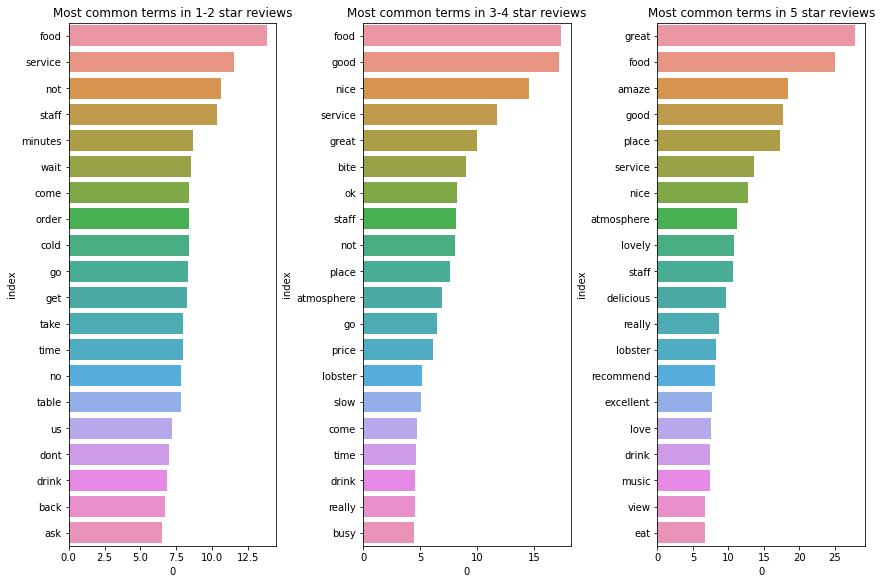

In [526]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

# Set up vectorizer
T = TfidfVectorizer(ngram_range=(1,1),
                    max_df=1.0,
                    min_df=10,
                    binary=True)

# Get counts
res = T.fit_transform(df_big_easy_clean['review_clean'])

# Set up dataframe
df_res = pd.DataFrame(data=res.todense(),
                      columns=T.get_feature_names())


for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_res_filt = df_res[[rev_min <= rev <= rev_max for rev in df_big_easy_clean['reviewRating']]]
    print(df_res_filt.shape)
    
    # Turn into plottable format
    df_plot = df_res_filt.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()[:20]
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

### DIY TF-IDF!

Get all words in our reviews

In [461]:
import itertools as it
from collections import defaultdict

dict_combos = defaultdict(int)
context_window = 3
n_gram = 2

def get_gram(text_tuple):
    return ' '.join(text_tuple)

df_filt = df_big_easy_clean.query(f'reviewRating>=1 and reviewRating<=2')
df_big_easy_clean['review_tfidf'] = [re.sub(r'(big easy|canary wharf)', '', s) for s in df_big_easy_clean['review_clean']]


# Loop through each set of reviews
all_reviews = []
for review_list in df_filt['review_parts_clean']:
    all_reviews.extend([re.sub(r'(\s)?(big easy|canary wharf)(\s)?', ' ', r) for r in review_list])
    
# Go through all review parts, and get all unique n gram combos, for tokens > 2 characters long
all_combos = []
for review_part in all_reviews:
    [re.sub(r'(big easy|canary wharf)', '', s) for s in df_big_easy_clean['review_clean']]
    tokens = [t for t in review_part.split() if len(t) > 2]
    
    # Then loop through context windows in tokens
    if len(tokens) < context_window:
        for combo in it.combinations(tokens, n_gram):
            gram = get_gram(combo)
            all_combos.append(gram)
            dict_combos[gram] += 1
    else:
        for i in range(len(tokens)-context_window+1):
            token_window = tokens[i:i+context_window]
            for combo in it.combinations(token_window, n_gram):
                gram = get_gram(combo)
                all_combos.append(gram)
                dict_combos[gram] += 1

                    
# Go through dictionary and dedupe if possible
for key in dict_combos.keys():
    
    key_rev = ' '.join(reversed(key.split()))
    if key_rev not in dict_combos.keys():
        continue
    
    # If the reverse key has a higher count, lump everything into that key. And vice-versa
    if dict_combos[key_rev] > dict_combos[key]:
        dict_combos[key_rev] += dict_combos[key]
        dict_combos[key] = 0

set_combos = sorted(set(all_combos))
print(len(set_combos))

11484


In [462]:
pd.set_option('display.max_rows', 500)
pd.DataFrame(dict_combos.items(), columns=['n_gram', 'count']).query('count>5').sort_values(by='count')

,n_gram,count
8028,minutes waiting,6
654,ordered lobster,6
664,take drinks,6
674,end bill,6
3649,table near,6
714,got served,6
4672,tgi fridays,6
902,restaurant busy,6
903,not busy,6
4563,better going,6


### Get co-occurrences of words (also known as collocations)

In [642]:
df_test['reviewBody'][190]

"First time coming here I was excited, and I am disappointed. I'll explain more... The food was too pricey for what it is, we ordered lobster and steak and the only thing that I said was worth the 20 pounds + was the steak! Order rib eye if you ever come don't bother with the lobster. We also ordered lobster Mac and cheese and it had just a sprinkling of lobster literally a sprinkling. It was cheesy but again not worth the 20 pounds price tag. The biggest no go was no burgers!? We wasn't even told before we sat down, extremely disappointed. The service was poor, we had to wait for our bill, drinks, and to be served. More the 15 to 20 minutes at times. I know you guys are stretched and busy but please explain about the wait. The hygiene in the toilets was not up to a good standard. Bins over flowing and sinks dirty, you wouldn't expect this from a Canary Wharf eatery. I always give places a second chance but I will only be coming back here if I have too."

In [644]:
df_test['reviewBody'][119]

"My bf and I booked the free flowing boozy brunch for 14:15 on Saturday. Pro - 1) lobster was nice Cons - 1) we waited 10mins for our initial order to be taken 2) the tables were packed so close together it was difficult to get in and out of the seats 3) music was way to loud 4) we asked for prosecco and we were served sparkling white wine (don't call it prosecco if it isn't) which tasted more like asti 5) the ribs were dry. If your looking for a decent free flowing brunch go downstairs to The Breakfast Club or take a 5min walk to The Humble Grape."

In [641]:
df_test = df_big_easy_clean[df_big_easy_clean['review_clean'].str.contains(r'(\brib\b)')].copy(deep=True)
df_test[]

/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,reviewBody,reviewRating,dateCreated,date_clean,review_clean,review_parts_clean,review_tfidf
8,Very poor service made worst by inedible food....,1.0,a year ago,2020-08-07,poor service make worst inedible food wait min...,"[poor service make worst inedible food, wait m...",poor service make worst inedible food wait min...
15,I was abit dissapointed because it was my birt...,3.0,a year ago,2020-08-07,abit dissapointed birthday boyfriend specifica...,[abit dissapointed birthday boyfriend specific...,abit dissapointed birthday boyfriend specifica...
26,Root beer float is an American traditional dri...,3.0,a year ago,2020-08-07,root beer float american traditional drink hop...,[root beer float american traditional drink ho...,root beer float american traditional drink hop...
62,"I ordered Taste-O-Rama which had BBQ Chicken, ...",3.0,a month ago,2021-07-08,order tasteorama bbq chicken dry rub st louis ...,[order tasteorama bbq chicken dry rub st louis...,order tasteorama bbq chicken dry rub st louis ...
64,Poor service and extremely poor value for mone...,1.0,a year ago,2020-08-07,poor service extremely poor value money portio...,"[poor service extremely poor value money, port...",poor service extremely poor value money portio...
83,Food is pretty solid but expensive for what it...,2.0,a month ago,2021-07-08,food pretty solid expensive be service absolut...,"[food pretty solid expensive, service absolute...",food pretty solid expensive be service absolut...
119,My bf and I booked the free flowing boozy brun...,1.0,a year ago,2020-08-07,bf book free flow boozy brunch saturday pro lo...,"[bf book free flow boozy brunch saturday, pro ...",bf book free flow boozy brunch saturday pro lo...
124,This place is a 3.5 star for me. I haven’t tri...,3.0,a year ago,2020-08-07,place star me havent try many bbq place london...,"[place , star, havent try many bbq place lond...",place star me havent try many bbq place london...
128,Great southern style food. The smoked bbq pork...,5.0,a year ago,2020-08-07,great southern style food smoke bbq pork rib e...,"[great southern style food, smoke bbq pork rib...",great southern style food smoke bbq pork rib e...
188,This place hits the spot for a southerner miss...,5.0,a month ago,2021-07-08,place hit spot southerner miss home obviously ...,"[place hit spot southerner miss home, obviousl...",place hit spot southerner miss home obviously ...


In [215]:
df_big_easy_clean['reviewBody'][6]

"Firstly, we had to queue for ages to be seated as there was only 1 member of staff checking reservations, taking temperatures and seating people. When my friend was downloading the track and trace app the attender tapped her phone which was an invasion on her personal space, and especially during this time. It also took quite a while to be served after being seated. The cocktails were extremely basic and watered down. Presentation was also poor, you could better looking cocktails and Whetherspoons. This is the 2nd time that I've been to Big Easy (last time I went to the one in Leicester Square) and both times my side of Mac & Cheese was forgotten. This time 3 different waiters came to ask if it had arrived and I just ended up cancelling it as I had already finished my starter and main. Overall the food was really good but that didn't save the overall experience."

In [463]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

BI_OR_TRI = 'bi'

# Get most common terms in 1-2, 3-4, and 5 star reviews
for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    print(f'\n\n***** Reviews in range {rev_min} to {rev_max} stars *****\n\n')
    
    # Filter for certain reviews
    df_filt = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    
    # Get corpus as list of all words in all reviews
    all_review_tokens = []
    for r in df_filt['review_clean']:
        to_exclude = ['canary', 'wharf', 'big', 'easy']
        all_review_tokens.extend([w for w in r.split() if w not in to_exclude])
    
    if BI_OR_TRI == 'bi':
        measures = BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(all_review_tokens, window_size=5)
    else:
        measures = TrigramAssocMeasures()
        finder = TrigramCollocationFinder.from_words(all_review_tokens, window_size=3) 

    # Ngrams with 'lobster' as a member
    word_filter = lambda *w: 'lobster' not in w
    
    print(df_filt.shape)

    # only bigrams that appear n+ times throughout all reviews
    finder.apply_freq_filter(5)
    
    # only bigrams that contain word filter
    # finder.apply_ngram_filter(word_filter)
    
    
    for idx, detail in enumerate(finder.score_ngrams(measures.likelihood_ratio)):
        #print(detail)
        (first, second) = detail[0]
        print(df_filt[(df_filt['review_clean'].str.contains(first))&(df_filt['review_clean'].str.contains(second))].shape[0],
              detail)
        if idx > 40:
            break
            
#     print('\nPMI')
#     for idx, detail in enumerate(finder.score_ngrams(measures.pmi)):
#         (first, second) = detail[0]
#         print(df_filt[(df_filt['review_clean'].str.contains(first))&(df_filt['review_clean'].str.contains(second))].shape[0],
#               detail)
#         if idx > 15:
#             break



***** Reviews in range 1 to 2 stars *****


(187, 7)
5 (('social', 'distancing'), 15.417501869191288)
30 (('food', 'cold'), 14.34037112297823)
6 (('mac', 'cheese'), 13.9218597353679)
10 (('waited', 'minutes'), 12.134786798344997)
7 (('wouldnt', 'recommend'), 11.142229059801736)
60 (('not', 'all'), 11.049328015470277)
5 (('bottomless', 'brunch'), 10.913238326047475)
15 (('service', 'charge'), 10.510117688709212)
5 (('whole', 'experience'), 9.973676445279322)
7 (('live', 'music'), 9.763118436270467)
34 (('wait', 'minutes'), 9.170872153868375)
21 (('service', 'poor'), 8.981605662409462)
8 (('worst', 'ever'), 8.882995210485658)
6 (('recommend', 'anyone'), 8.862374746860649)
11 (('took', 'arrive'), 8.29932373738944)
3 (('walked', 'away'), 7.583978162344721)
4 (('lobster', 'roll'), 7.53802509202181)
8 (('even', 'though'), 7.389350732513282)
5 (('value', 'money'), 7.387596879566387)
18 (('first', 'time'), 6.706293967825052)
11 (('not', 'worth'), 6.456487124384884)
17 (('long', 'time'), 6.25

(4, 5)
(3, 5)
(4, 5)


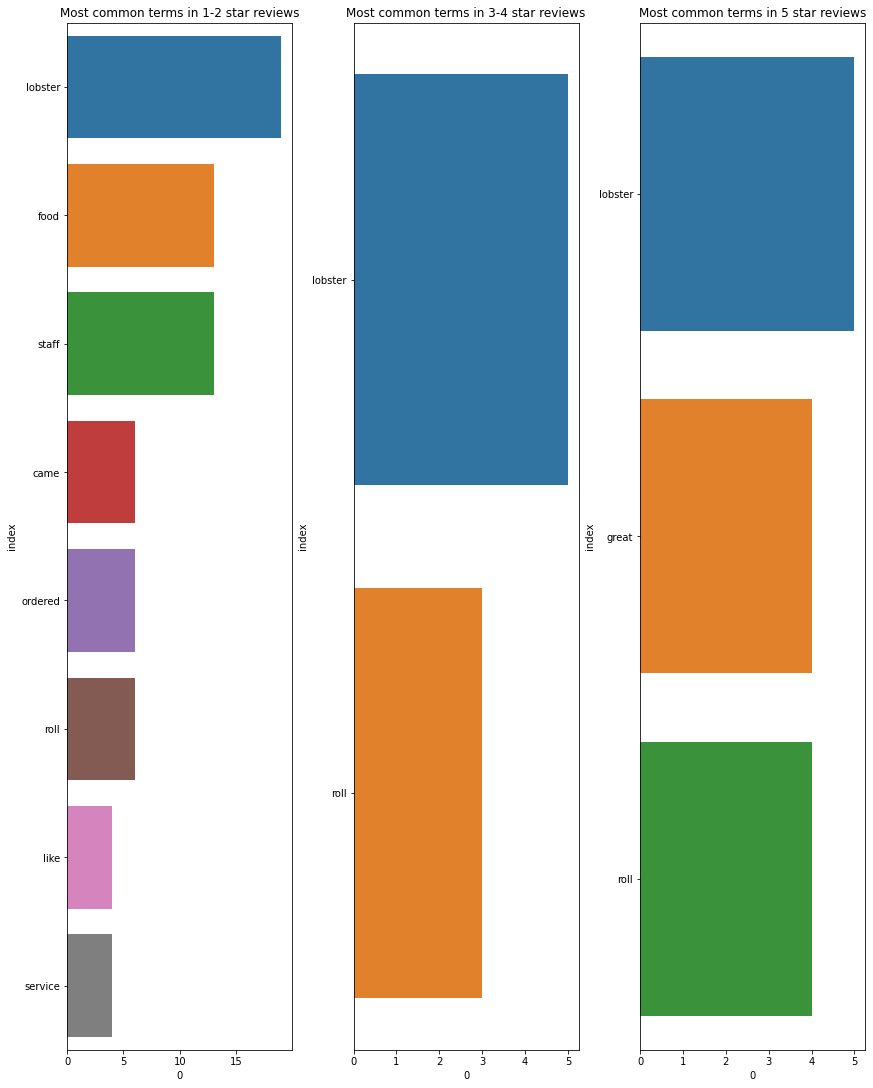

In [180]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

word_filt = 'lobster roll'

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    df_filt = df_filt[df_filt['reviewBody'].str.contains(word_filt)]
    print(df_filt.shape)
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(1,1),
                        max_df=1.0,
                        min_df=3,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

I was abit dissapointed because it was my birthday and my boyfriend specifically told staff but they didnt acknowledge this. Food was ok except the ribs was abit under cook and dry so didnt finish it. 

They're not doing much for Birthday Celebrants! 

This restaurant was booked for me and my best friend as a birthday surprise, as well as various other things. In which I was not disappointed. Couldn't believe I hadn't heard of this place, I must be  

My partner had booked the restaurant for my 27th birthday as a surprise, we were very excited. On arrival, the receptionist was not wearing a mask & a couple of other staff were lowering their masks d 

Came here for my mother’s birthday, she’s been to the Covent Garden branch and loved it so we decided to come to canary wharf branch ABSOLUTELY HORRIBLE food was cold and bland won’t be returning. 

The worst experience ever, came out to celebrate my daughters birthday, food wasn't cook properly. Service was below standard, ask for Oreo mi

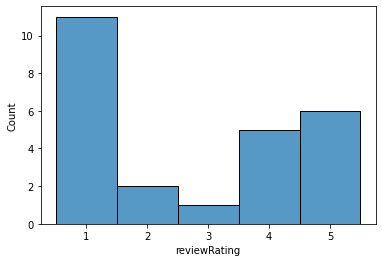

In [127]:
df_test = df_big_easy_clean.query(f'reviewRating>=1 and reviewRating<=5')
# df_test = df_test[(df_test['review_clean'].str.contains('lobster'))&(df_test['review_clean'].str.contains('roll'))]
df_test = df_test[df_test['review_clean'].str.contains('birthday')]
sns.histplot(df_test['reviewRating'],
             bins=[0.5,1.5,2.5,3.5,4.5,5.5])
for r in df_test['reviewBody']:
    print(r[:200], '\n')
#df_test[df_test['review_clean'].str.contains('lunch')]

In [167]:
weekday_ratings = []

day_prefixes = r'[a-z]{1,}day'
for idx, row in df_big_easy_clean.iterrows():
    matches = re.search(day_prefixes, row['reviewBody'].lower())
    if matches is not None:
        weekday_ratings.append([row['reviewRating'], matches.group()])
        print(row['reviewRating'], matches.group(), ':', row['reviewBody'][:300], '\n')
        
pd.DataFrame(weekday_ratings, columns=['rating', 
                                       'day']).groupby('day')['rating'].agg(('mean', 
                                                                             'count')).sort_values(by='count',
                                                                                                   ascending=False)

3.0 birthday : I was abit dissapointed because it was my birthday and my boyfriend specifically told staff but they didnt acknowledge this. Food was ok except the ribs was abit under cook and dry so didnt finish it. 

4.0 birthday : They're not doing much for Birthday Celebrants! 

5.0 birthday : This restaurant was booked for me and my best friend as a birthday surprise, as well as various other things. In which I was not disappointed. Couldn't believe I hadn't heard of this place, I must be living under a rock!! All four of us were seated, given our menus which and served pretty quickly. W 

2.0 tuesday : Restaurant was not busy, yet the service received was terrible. Food came pretty quickly, but the service after that was terrible. Tried to charge us for an additional meal, £25. Luckily I checked the bill. Took them HALF AN HOUR to rectify, then I was cheekily told it was a "system error". It was n 

5.0 today : Was really excited to be back here and was not disappointed. Great foo

,mean,count
day,,
birthday,2.869565,23
saturday,4.000000,10
tuesday,2.500000,8
today,2.857143,7
friday,2.166667,6
monday,4.000000,3
sunday,4.333333,3
bday,3.500000,2
weekday,5.000000,2


In [182]:
weekday_ratings = []

day_prefixes = r'(lunch|dinner)'
for idx, row in df_big_easy_clean.iterrows():
    matches = re.search(day_prefixes, row['reviewBody'].lower())
    if matches is not None:
        weekday_ratings.append([row['reviewRating'], matches.group()])
        print(row['reviewRating'], matches.group(), ':', row['reviewBody'][:300], '\n')
        
pd.DataFrame(weekday_ratings, columns=['rating', 
                                       'day']).groupby('day')['rating'].agg(('mean', 
                                                                             'count')).sort_values(by='count',
                                                                                                   ascending=False)

1.0 lunch : Waited for 15m to get served at the bar, wasting a sizeable chunk of my lunch break. Staff constantly stayed at other end of the bar, addressing customers who just appeared. Got annoyed and left. Express lunch, only if you managed to get the staff to even acknowledge you! 

5.0 dinner : This restaurant was booked for me and my best friend as a birthday surprise, as well as various other things. In which I was not disappointed. Couldn't believe I hadn't heard of this place, I must be living under a rock!! All four of us were seated, given our menus which and served pretty quickly. W 

5.0 lunch : It is a good place to be in lunch time, monday to friday, the express lunch is massive and good quality, if you take 2 courses with drink and service charge is about £15. I have to say that i've been there also in a weekend with my kids, in the website they saying ITS FREE MEAL FOR KIDS.....and it i 

5.0 lunch : The big easy is super! Great modern architecture definitely worth to v

,mean,count
day,,
lunch,4.000000,21
dinner,2.857143,14


### Entity recognition

Get english language and test parsing on one example

In [79]:
nlp = spacy.load("en_core_web_lg")

In [391]:
row = 47
doc = nlp(df_big_easy_eng.reset_index()['reviewBody'][row])

print(doc[:20], df_big_easy_eng.reset_index()['reviewRating'][row], sep='\n')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, spacy.explain(token.dep_),
            token.shape_, token.is_alpha, token.is_stop, sep=', ')

The atmosphere was good. The wings were delicious. I could not eat the brisket as it was so
2.0
The, the, DET, DT, det, determiner, Xxx, True, True
atmosphere, atmosphere, NOUN, NN, nsubj, nominal subject, xxxx, True, False
was, be, AUX, VBD, ROOT, None, xxx, True, True
good, good, ADJ, JJ, acomp, adjectival complement, xxxx, True, False
., ., PUNCT, ., punct, punctuation, ., False, False
The, the, DET, DT, det, determiner, Xxx, True, True
wings, wing, NOUN, NNS, nsubj, nominal subject, xxxx, True, False
were, be, AUX, VBD, ROOT, None, xxxx, True, True
delicious, delicious, ADJ, JJ, acomp, adjectival complement, xxxx, True, False
., ., PUNCT, ., punct, punctuation, ., False, False
I, I, PRON, PRP, nsubj, nominal subject, X, True, True
could, could, AUX, MD, aux, auxiliary, xxxx, True, True
not, not, PART, RB, neg, negation modifier, xxx, True, True
eat, eat, VERB, VB, ROOT, None, xxx, True, False
the, the, DET, DT, det, determiner, xxx, True, True
brisket, brisket, NOUN, NN, dobj, dire

Visualise dependencies

In [392]:
spacy.displacy.render(doc,
                      options={'compact':True})

In [393]:
spacy.displacy.render(doc, style='ent', jupyter=True)

Go one step further, and label data with dependencies

In [394]:
# Document is list of sentences, .sents is a generator object that allows us to grab these
sentences = list(doc.sents)

# Get function to extract information from sentences
def get_dependency_data(sentence):
    for word in sentence:
        output_prelim = f'{word} has '
        dep = word.dep_
        dep_first_letter = dep[0] if dep is not None else None

        if spacy.explain(dep) is not None:
            suffix = f'label {dep} ({spacy.explain(dep)})'
        else:
            suffix = f'label {dep}'
        
        print(output_prelim + suffix)
        

for s in sentences:
    get_dependency_data(s)
    print('---------------\n')
        
        

The has label det (determiner)
atmosphere has label nsubj (nominal subject)
was has label ROOT
good has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

The has label det (determiner)
wings has label nsubj (nominal subject)
were has label ROOT
delicious has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

I has label nsubj (nominal subject)
could has label aux (auxiliary)
not has label neg (negation modifier)
eat has label ROOT
the has label det (determiner)
brisket has label dobj (direct object)
as has label mark (marker)
it has label nsubj (nominal subject)
was has label advcl (adverbial clause modifier)
so has label advmod (adverbial modifier)
fatty has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

The has label det (determiner)
waiter has label nsubj (nominal subject)
had has label ROOT
his has label poss (possession modifier)
mask has label dobj (direct object)
under has 

### LDA

Get counts for all 1-2 grams in reviews

In [348]:
# For topic analysis, remove very common terms that appear in every topic
reviews_less_stopwords = df_big_easy_clean['review_clean'].apply(lambda review: re.sub(r'(food)', '', review))

list_of_list_of_tokens = [rev.split() for rev in reviews_less_stopwords]
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

In [370]:
num_topics = 20
lda_model = LdaModel(corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary_LDA, 
                     passes=3,
                     alpha=[0.01]*num_topics,
                     eta=[0.01]*len(dictionary_LDA.keys()))

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.017*"great" + 0.016*"get" + 0.015*"service" + 0.013*"give" + 0.012*"staff" + 0.010*"good" + 0.010*"rib" + 0.009*"go" + 0.009*"its" + 0.008*"disappoint"

1: 0.032*"good" + 0.018*"service" + 0.018*"place" + 0.016*"great" + 0.015*"come" + 0.015*"go" + 0.013*"time" + 0.012*"restaurant" + 0.010*"it" + 0.009*"would"

2: 0.033*"great" + 0.028*"view" + 0.024*"staff" + 0.024*"good" + 0.024*"lovely" + 0.018*"excellent" + 0.018*"place" + 0.017*"really" + 0.017*"atmosphere" + 0.016*"back"

3: 0.022*"service" + 0.017*"nice" + 0.015*"table" + 0.015*"really" + 0.014*"go" + 0.014*"place" + 0.013*"us" + 0.013*"would" + 0.012*"restaurant" + 0.009*"friends"

4: 0.018*"table" + 0.016*"service" + 0.015*"good" + 0.014*"ask" + 0.014*"place" + 0.013*"order" + 0.012*"staff" + 0.012*"time" + 0.012*"come" + 0.011*"go"

5: 0.016*"lobster" + 0.015*"order" + 0.013*"come" + 0.013*"place" + 0.011*"good" + 0.010*"amaze" + 0.010*"go" + 0.009*"us" + 0.009*"also" + 0.009*"get"

6: 0.026*"us" + 0.018*"disappoint" + 0

7     68
9     65
3     48
4     43
2     38
15    37
19    34
1     33
11    31
16    26
12    24
5     23
17    22
8     22
0     19
18    19
10    17
14    17
13    15
6     13
Name: topic, dtype: int64


<AxesSubplot:xlabel='rating', ylabel='topic'>

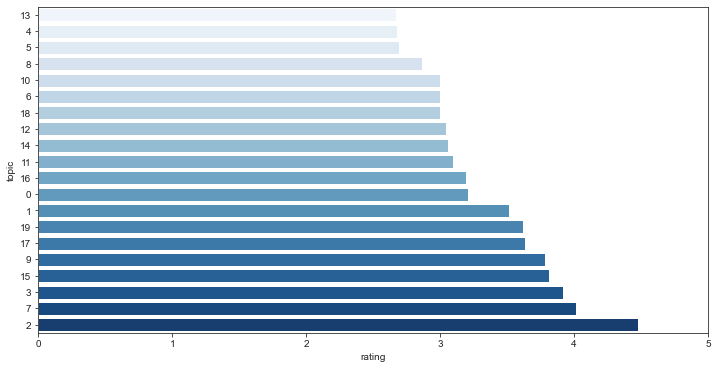

In [372]:
df_sentiment_by_topic = pd.DataFrame(data=sentiment_by_topic,
                                     columns=['rating', 'topic'])

df_sentiment_by_topic['topic'] = df_sentiment_by_topic['topic'].astype(str)

print(df_sentiment_by_topic['topic'].value_counts())


plt.figure(figsize=(12,6))
plt.xlim((0,5))

# Collapse
sns.barplot(data=df_sentiment_by_topic.groupby('topic')['rating'].mean().reset_index().sort_values(by='rating'),
              y='topic',
              x='rating',
            palette='Blues')

In [61]:
# %matplotlib inline
# import pyLDAvis
# import pyLDAvis.gensim_models
# vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
# pyLDAvis.enable_notebook()
# pyLDAvis.display(vis)